# Anomaly Detection: From Decision Tree to Generative Model 
**Author**: Jvachier <br>
**Date**: 2024 <br>

Anamaly detection plays an important role in predictive maintenance. Often anomalies are particularly difficult to identify. In this notebook, different models are compared <br>
1. Isolation Forest <br>
2. AutoEncoders: <br>
    a - Deep Neural Network <br>
    b - Recurrent Neural Network (LSTM)<br>
3. Variational AutoEncoder: Recurrent Neural Network (LSTM)

In [2]:
import opendatasets as od
od.download('https://www.kaggle.com/datasets/arnabbiswas1/microsoft-azure-predictive-maintenance')

Skipping, found downloaded files in ".\microsoft-azure-predictive-maintenance" (use force=True to force download)


In [ ]:
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np


# CPU & GPU

# Loading Data

In [4]:
sensor_Data = pd.read_csv('microsoft-azure-predictive-maintenance/PdM_telemetry.csv')
failure = pd.read_csv('microsoft-azure-predictive-maintenance/PdM_failures.csv')

# Data Processing

In [5]:
sensor_Data['datetime'] = pd.to_datetime(sensor_Data["datetime"])
failure['datetime'] = pd.to_datetime(failure["datetime"])

sensor_Data.rename(columns={"datetime": "time"},inplace=True)
failure.rename(columns={"datetime": "time"},inplace=True)

failure.loc[failure["failure"] != 0, "failure"] = 1
failure["failure"] = failure["failure"].astype("int64")

sensor_Data.set_index('time',inplace=True)
failure.set_index('time',inplace=True)

# Select a Machine

In [6]:
machine_name = 10

In [7]:
sensor_Data = sensor_Data.query("machineID == @machine_name")
failure = failure.query("machineID == @machine_name")

In [8]:
sensor_Data_machine = sensor_Data.copy()
sensor_Data_machine.drop(columns='machineID', inplace=True)

In [9]:
scaler = StandardScaler()
np_scaled = scaler.fit_transform(sensor_Data_machine.values)#.reshape(-1, 1))
data = pd.DataFrame(np_scaled)

In [10]:
import torch
from torch.utils.data import Dataset, DataLoader

import torch.nn as nn
import torch.optim as optim

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create a PyTorch dataset class
class MachineDataset(Dataset):
    def __init__(self, data, sequence_length=50):
        self.data = torch.FloatTensor(data)
        self.sequence_length = sequence_length
        
    def __len__(self):
        return len(self.data) - self.sequence_length + 1
    
    def __getitem__(self, idx):
        return self.data[idx:idx + self.sequence_length]

# VAE model definition
class VAE(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size):
        super(VAE, self).__init__()
        
        # Encoder
        self.lstm_encoder = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc_mu = nn.Linear(hidden_size, latent_size)
        self.fc_var = nn.Linear(hidden_size, latent_size)
        
        # Decoder
        self.decoder_input = nn.Linear(latent_size, hidden_size)
        self.lstm_decoder = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.output_layer = nn.Linear(hidden_size, input_size)
        
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
        
    def forward(self, x):
        # Encoder
        lstm_out, _ = self.lstm_encoder(x)
        lstm_out = lstm_out[:, -1, :]  # Take last hidden state
        
        mu = self.fc_mu(lstm_out)
        log_var = self.fc_var(lstm_out)
        z = self.reparameterize(mu, log_var)
        
        # Decoder
        h = self.decoder_input(z)
        h = h.unsqueeze(1).repeat(1, x.size(1), 1)
        lstm_out, _ = self.lstm_decoder(h)
        output = self.output_layer(lstm_out)
        
        return output, mu, log_var

# Initialize preprocessing
scaler = StandardScaler()
scaled_data = scaler.fit_transform(sensor_Data_machine)

# Create dataset and dataloader
dataset = MachineDataset(scaled_data)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

# Model parameters
input_size = sensor_Data_machine.shape[1]  # number of features
hidden_size = 64
latent_size = 20

# Initialize model
model = VAE(input_size, hidden_size, latent_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Loss function
def loss_function(recon_x, x, mu, log_var):
    reconstruction_loss = nn.MSELoss(reduction='sum')(recon_x, x)
    kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return reconstruction_loss + kl_loss

Epoch [10/100], Loss: 23231.6150
Epoch [20/100], Loss: 23293.8022
Epoch [30/100], Loss: 23134.9817
Epoch [40/100], Loss: 23118.2635
Epoch [50/100], Loss: 23104.8531
Epoch [60/100], Loss: 23097.5465
Epoch [70/100], Loss: 23073.0575
Epoch [80/100], Loss: 23034.8125
Epoch [90/100], Loss: 23090.9869
Epoch [100/100], Loss: 23091.0090
Training finished!


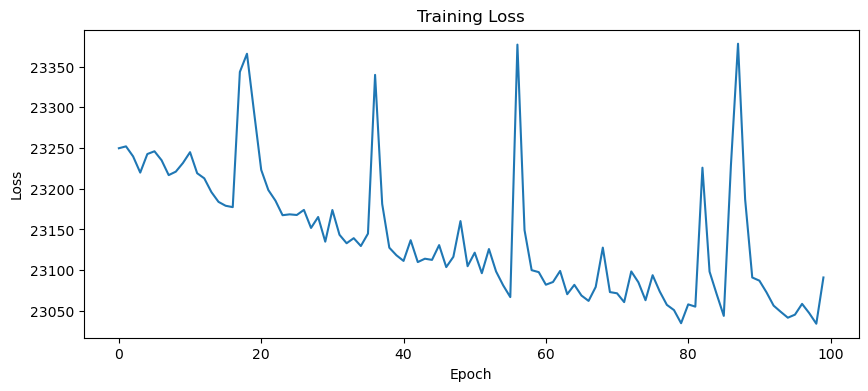

In [13]:
# Training parameters
num_epochs = 100
batch_size = 128
losses = []

# Training loop
for epoch in range(num_epochs):
    total_loss = 0
    for batch in dataloader:
        batch = batch.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        recon_batch, mu, log_var = model(batch)
        
        # Calculate loss
        loss = loss_function(recon_batch, batch, mu, log_var)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    # Average loss for the epoch
    avg_loss = total_loss / len(dataloader)
    losses.append(avg_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

print('Training finished!')

# Plot training loss
plt.figure(figsize=(10, 4))
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

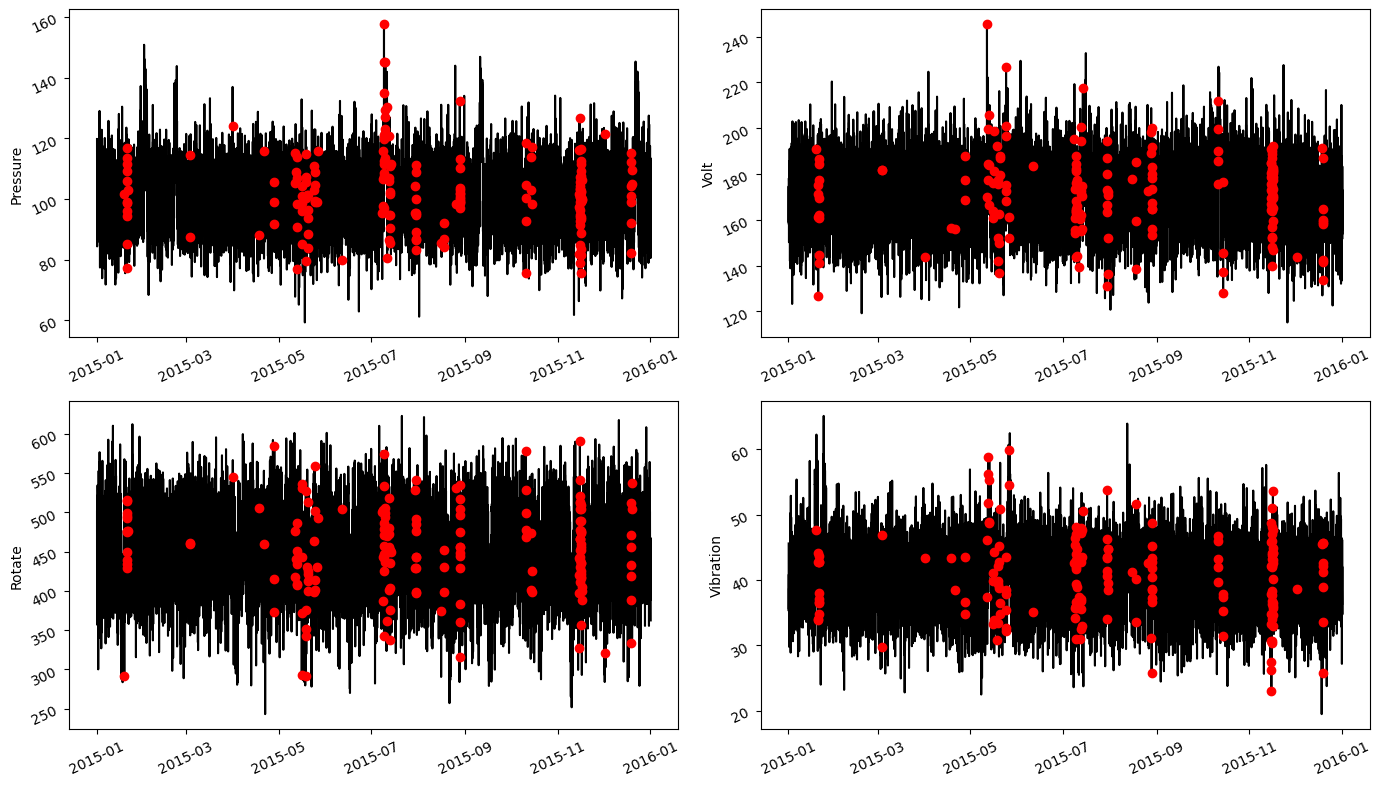

In [14]:
time_step = 50
def create_sequences(values: list) -> np.array:
    output = []
    for i in range(len(values) - time_step + 1):
        output.append(values[i : (i + time_step)])
    return np.stack(output)

x_train = create_sequences(scaled_data)

# Get reconstruction error
reconstructions = model(torch.FloatTensor(x_train).to(device))[0].cpu().detach().numpy()
mse = np.mean(np.square(x_train - reconstructions), axis=(1,2))

# Convert to pandas series with proper index
anomaly_vae_torch_scores = pd.Series(mse, name="anomaly_scores")
anomaly_vae_torch_scores.index = sensor_Data[(time_step - 1):].index

# Set threshold and identify anomalies
threshold = anomaly_vae_torch_scores.quantile(0.98)
anomalous = anomaly_vae_torch_scores > threshold

# Create visualization
fig, axs = plt.subplots(2, 2, figsize=(14, 8))

# Plot pressure
axs[0, 0].plot(sensor_Data_machine.index, sensor_Data_machine[['pressure']], "k")
axs[0, 0].plot(
    sensor_Data_machine.index[(time_step - 1):][anomalous],
    sensor_Data_machine[['pressure']][(time_step - 1):][anomalous],
    "ro"
)
axs[0, 0].set_ylabel("Pressure")
axs[0, 0].tick_params(labelrotation=25)

# Plot rotate
axs[1, 0].plot(sensor_Data_machine.index, sensor_Data_machine[['rotate']], "k")
axs[1, 0].plot(
    sensor_Data_machine.index[(time_step - 1):][anomalous],
    sensor_Data_machine[['rotate']][(time_step - 1):][anomalous],
    "ro"
)
axs[1, 0].set_ylabel("Rotate")
axs[1, 0].tick_params(labelrotation=25)

# Plot volt
axs[0, 1].plot(sensor_Data_machine.index, sensor_Data_machine[['volt']], "k")
axs[0, 1].plot(
    sensor_Data_machine.index[(time_step - 1):][anomalous],
    sensor_Data_machine[['volt']][(time_step - 1):][anomalous],
    "ro"
)
axs[0, 1].set_ylabel("Volt")
axs[0, 1].tick_params(labelrotation=25)

# Plot vibration
axs[1, 1].plot(sensor_Data_machine.index, sensor_Data_machine[['vibration']], "k")
axs[1, 1].plot(
    sensor_Data_machine.index[(time_step - 1):][anomalous],
    sensor_Data_machine[['vibration']][(time_step - 1):][anomalous],
    "ro"
)
axs[1, 1].set_ylabel("Vibration")
axs[1, 1].tick_params(labelrotation=25)

fig.tight_layout(pad=1.2)
plt.show()

C:\Users\ammar\AppData\Local\Temp\ipykernel_29996\3257000130.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.data = torch.tensor(data, dtype=torch.float32).clone().detach()


Epoch [1/10], Loss: 200.2746
Epoch [2/10], Loss: 200.1083
Epoch [3/10], Loss: 200.1067
Epoch [4/10], Loss: 200.1064
Epoch [5/10], Loss: 200.1063
Epoch [6/10], Loss: 200.1062
Epoch [7/10], Loss: 200.1062
Epoch [8/10], Loss: 200.1061
Epoch [9/10], Loss: 200.1061
Epoch [10/10], Loss: 200.1060


C:\Users\ammar\AppData\Local\Temp\ipykernel_29996\3257000130.py:130: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  anomaly_values = sensor_Data_machine[sensor_name].iloc[time_step - 1:][anomaly_indices]


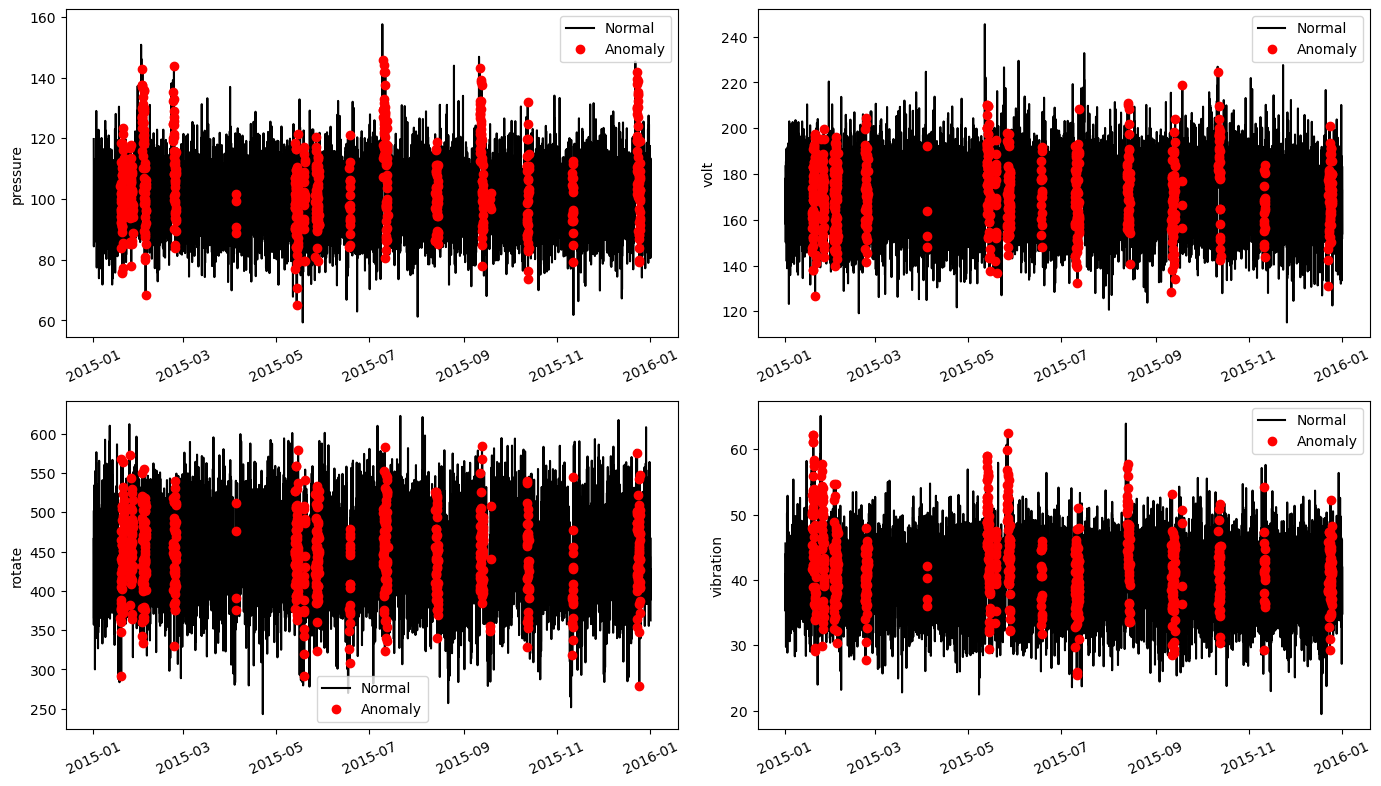

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader

# Configuration
TIME_STEP = 50
LATENT_DIM = 2
BATCH_SIZE = 128
EPOCHS = 10
ANOMALY_THRESHOLD = 0.98

# 1. Data Preparation (Assuming data is preprocessed and scaled)
def create_sequences(values, time_step=TIME_STEP):
    output = []
    for i in range(len(values) - time_step + 1):
        output.append(values[i : (i + time_step)])
    return np.stack(output)

class SensorDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32).clone().detach()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# 2. VAE Model Definition (Without LSTM)
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        self.fc_mean = nn.Linear(32, latent_dim)
        self.fc_logvar = nn.Linear(32, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),
            nn.ReLU()
        )

    def encode(self, x):
        h = self.encoder(x)
        mean, logvar = self.fc_mean(h), self.fc_logvar(h)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        x_recon = self.decode(z)
        return x_recon, mean, logvar

# 3. Training Loop
def train_vae(vae, dataloader, optimizer, epochs=EPOCHS, device='cpu'):
    vae.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in dataloader:
            batch = batch.to(device)
            optimizer.zero_grad()
            x_recon, mean, logvar = vae(batch)
            recon_loss = nn.MSELoss(reduction='sum')(x_recon, batch)
            kl_div = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
            loss = recon_loss + kl_div
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f'Epoch [{epoch+1}/{epochs}], Loss: {total_loss / len(dataloader.dataset):.4f}')

# 4. Anomaly Detection
def detect_anomalies(vae, dataloader, device='cpu'):
    vae.eval()
    mse_list = []
    with torch.no_grad():
        for batch in dataloader:
            batch = batch.to(device)
            x_recon, _, _ = vae(batch)
            mse = torch.mean(torch.square(batch - x_recon), dim=1)
            mse_list.append(mse.cpu().numpy())
    return np.concatenate(mse_list)

# 5. Visualization
def visualize_anomalies(sensor_Data_machine, anomaly_scores, time_step=TIME_STEP, anomaly_threshold=ANOMALY_THRESHOLD):
    threshold = np.quantile(anomaly_scores, anomaly_threshold)
    anomalous = anomaly_scores > threshold

    fig, axs = plt.subplots(2, 2, figsize=(14, 8))

    # Ensure sensor_Data_machine is a DataFrame
    if not isinstance(sensor_Data_machine, pd.DataFrame):
        raise ValueError("sensor_Data_machine must be a pandas DataFrame")

    # Anomaly indices
    anomaly_indices = np.where(anomalous)[0]

    # Plotting function
    def plot_sensor_data(ax, sensor_name, color):
        ax.plot(sensor_Data_machine.index, sensor_Data_machine[sensor_name], "k", label="Normal")
        anomaly_times = sensor_Data_machine.index[time_step - 1:][anomaly_indices]
        anomaly_values = sensor_Data_machine[sensor_name].iloc[time_step - 1:][anomaly_indices]
        ax.plot(anomaly_times, anomaly_values, "ro", label="Anomaly")
        ax.set_ylabel(sensor_name)
        ax.tick_params(axis='x', rotation=25)
        ax.legend()

    # Plot each sensor
    plot_sensor_data(axs[0, 0], 'pressure', 'blue')
    plot_sensor_data(axs[1, 0], 'rotate', 'green')
    plot_sensor_data(axs[0, 1], 'volt', 'purple')
    plot_sensor_data(axs[1, 1], 'vibration', 'orange')

    fig.tight_layout(pad=1.2)
    plt.show()

# 6. Main Execution
if __name__ == '__main__':
    sensor_Data = pd.read_csv('microsoft-azure-predictive-maintenance/PdM_telemetry.csv')
    sensor_Data['datetime'] = pd.to_datetime(sensor_Data["datetime"])
    sensor_Data.rename(columns={"datetime": "time"}, inplace=True)
    sensor_Data.set_index('time', inplace=True)
    machine_name = 10
    sensor_Data = sensor_Data.query("machineID == @machine_name")
    sensor_Data_machine = sensor_Data.copy()
    sensor_Data_machine.drop(columns='machineID', inplace=True)
    scaler_auto = StandardScaler()
    np_scaled = scaler_auto.fit_transform(sensor_Data_machine)
    x_train_np = create_sequences(np_scaled)
    x_train = torch.tensor(x_train_np, dtype=torch.float32)

    # Dataset and DataLoader
    sensor_dataset = SensorDataset(x_train)
    dataloader = DataLoader(sensor_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Model, Optimizer, and Device
    input_dim = x_train.shape[2]  # Number of sensor features
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    vae = VAE(input_dim, LATENT_DIM).to(device)
    optimizer = optim.Adam(vae.parameters(), lr=1e-3)

    # Train the VAE
    train_vae(vae, dataloader, optimizer, device=device)

    # Detect anomalies
    anomaly_scores = detect_anomalies(vae, dataloader, device=device)

    # Visualize anomalies
    visualize_anomalies(sensor_Data_machine, anomaly_scores)

In [ ]:
%pip uninstall pymupdf